1. import and preprocess data
2. split to train and test set
3. choose train size (input: trainset, percetnage, output small trainset)
4. cross validate and train model, select optimum parameter with validation result

# 1. import and preprocess data

In [29]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline


In [30]:
df1 = pd.read_csv('phishing.csv').astype('category')
df1.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


next one hot encode columns with 3 unique values, and process columns with values such as (-1,1) to (0,1)

In [31]:
encode_col=[]
for col in df1.columns:
    if df1[col].nunique()==3:
        encode_col.append(col)
df1_encode=pd.get_dummies(df1, prefix=encode_col, columns=encode_col)
df1_encoded = df1_encode.replace(-1, 0)

# 2. Split train and test set

In [32]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1_encoded, test_size = 0.4, random_state = 121)


# 3. choose train size (input: trainset, percetnage, output small trainset)

In [33]:
def trainsize(fullset,percent):
    discard, smalltrainset = train_test_split(fullset, test_size = percent, random_state = 1)
    return (smalltrainset)

In [34]:
y_test=test[['Result']].values
#y_test=y_test['Result'].ravel()
X_test=test.drop(columns=['Result']).values

# train model

In [35]:
y_train=train[['Result']].values
#y_train=y_train['Result'].ravel()
X_train=train.drop(columns=['Result']).values

# Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


In [9]:

def dtbestpara(start_leaf_n, end_leaf_n, X_train, y_train, X_test, y_test):
    
    f1_test = []
    f1_train = []
    max_depth = list(range(1,25))
    for depth in max_depth:         
            clf = DecisionTreeClassifier(max_depth=depth, random_state=123, min_samples_leaf=1, criterion='gini')
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
            
      
    plt.plot(max_depth, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(max_depth, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Max Tree Depth')
    
    plt.title('Decision tree')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    #grid search space:
    #10 values of min_samples leaf from 0.5% sample to 5% of the training data
    #20 values of max_depth from 1 to 20
    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,10).round().astype('int'), 'max_depth':np.arange(1,20)}
    cvtree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=10, n_jobs=-1)
    cvtree.fit(X_train, y_train)
    print("best tuned parameters are:")
    print(cvtree.best_params_)
    return (cvtree.best_params_['max_depth'], cvtree.best_params_['min_samples_leaf'])

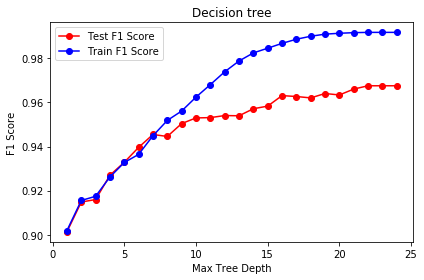

best tuned parameters are:
{'max_depth': 8, 'min_samples_leaf': 33}


In [10]:
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth, min_samples_leaf = dtbestpara(start_leaf_n,end_leaf_n,X_train, y_train, X_test, y_test,)
estimator_phish = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=121)
#train_samp_phish, DT_train_score_phish, DT_fit_time_phish, DT_pred_time_phish = plot_learning_curve(estimator_phish, X_train, y_train,title="Decision Tree Phishing Data")
#final_classifier_evaluation(estimator_phish, X_train, X_test, y_train, y_test)

In [11]:
def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = [];  #model performance score (f1)
    cv_mean = [];  #model performance score (f1)
    fit_mean = []; #model fit/training time
    pred_mean = [];  #model test/prediction times
    train_sizes=(np.linspace(.05, 0.99, 10)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time']))
    
    train_mean = np.array(train_mean)
    cv_mean = np.array(cv_mean)
    fit_mean = np.array(fit_mean)
    pred_mean = np.array(pred_mean)
    
    plot_LC(train_sizes, train_mean, cv_mean, title)
    plot_times(train_sizes, fit_mean,  pred_mean,  title)
    
    return train_sizes, cv_mean, fit_mean, pred_mean
    

def plot_LC(train_sizes, train_mean,  cv_mean,  title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Testing Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean,  pred_mean,  title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_mean, 'o-', color="r", label="Prediction Time (s)")

    plt.legend(loc="best")
    plt.show()


import timeit

def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print("Evaluation Metrics Using Test Data")
    print("Training Time (s):   "+"{:.5f}".format(training_time))
    print("Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    print ("AUC:  "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision))
    print ("Recall:  "+"{:.2f}".format(recall))
    plt.figure()
    plt.show()

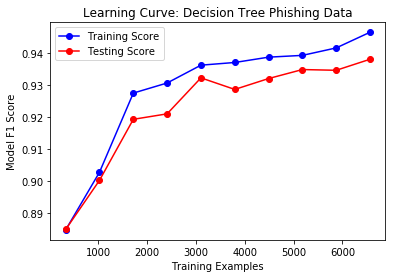

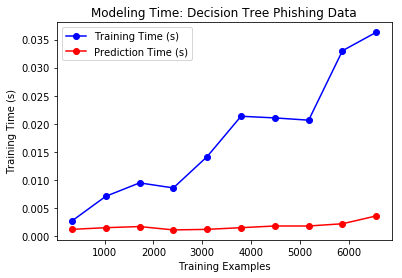

Evaluation Metrics Using Test Data
Training Time (s):   0.01934
Prediction Time (s): 0.00474

F1 Score:  0.93
Accuracy:  0.93
AUC:  0.93
Precision: 0.93
Recall:  0.93


<Figure size 432x288 with 0 Axes>

In [12]:
train_samp_phish, DT_train_score_phish, DT_fit_time_phish, DT_pred_time_phish = plot_learning_curve(estimator_phish, X_train, y_train,title="Decision Tree Phishing Data")
final_classifier_evaluation(estimator_phish, X_train, X_test, y_train, y_test)


# Boosting

In [13]:
import warnings; warnings.simplefilter('ignore')
from sklearn.ensemble import GradientBoostingClassifier


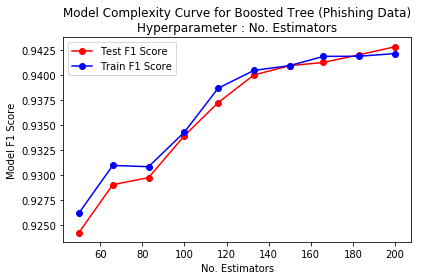

In [14]:
max_depth=3
min_samples_leaf=50
title="Model Complexity Curve for Boosted Tree (Phishing Data)\nHyperparameter : No. Estimators"

f1_test = []
f1_train = []
n_estimators = np.linspace(50,200,10).astype('int')
for i in n_estimators:         
        clf = GradientBoostingClassifier(n_estimators=i, max_depth=int(max_depth/2), min_samples_leaf=int(min_samples_leaf/2), random_state=100,)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
plt.plot(n_estimators, f1_test, 'o-', color='r', label='Test F1 Score')
plt.plot(n_estimators, f1_train, 'o-', color = 'b', label='Train F1 Score')
plt.ylabel('Model F1 Score')
plt.xlabel('No. Estimators')
    
plt.title(title)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [15]:
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]

param_grid = {'min_samples_leaf': np.linspace(start_leaf_n,end_leaf_n,3).round().astype('int'),'max_depth': np.arange(1,3),'n_estimators': np.linspace(50,200,3).round().astype('int'),'learning_rate': np.linspace(.001,.1,3)}

boost = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=param_grid, cv=10, n_jobs=-1)
boost.fit(X_train, y_train)
print("Per Hyperparameter tuning, best parameters are:")
print(boost.best_params_)
max_depth = boost.best_params_['max_depth']
min_samples_leaf = boost.best_params_['min_samples_leaf']
n_estimators = boost.best_params_['n_estimators']
learning_rate = boost.best_params_['learning_rate']

Per Hyperparameter tuning, best parameters are:
{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 182, 'n_estimators': 200}


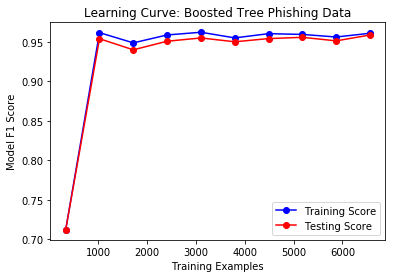

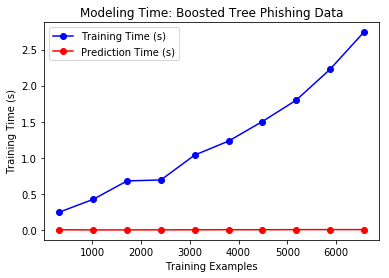

Evaluation Metrics Using Test Data
Training Time (s):   0.90605
Prediction Time (s): 0.01661

F1 Score:  0.95
Accuracy:  0.95
AUC:  0.95
Precision: 0.95
Recall:  0.96


<Figure size 432x288 with 0 Axes>

In [16]:
estimator_phish = GradientBoostingClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators, learning_rate=learning_rate, random_state=100)

train_samp_phish, BT_train_score_phish, BT_fit_time_phish, BT_pred_time_phish = plot_learning_curve(estimator_phish, X_train, y_train,title="Boosted Tree Phishing Data")
final_classifier_evaluation(estimator_phish, X_train, X_test, y_train, y_test)


# NN

In [17]:
from sklearn.neural_network import MLPClassifier

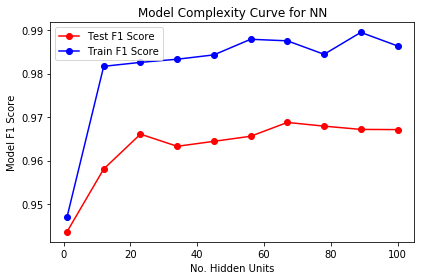

In [18]:
title="Model Complexity Curve for NN"
f1_test = []
f1_train = []
hlist = np.linspace(1,100,10).astype('int')
for i in hlist:
    clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic', learning_rate_init=0.05, random_state=100)
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    f1_test.append(f1_score(y_test, y_pred_test))
    f1_train.append(f1_score(y_train, y_pred_train))
      
plt.plot(hlist, f1_test, 'o-', color='r', label='Test F1 Score')
plt.plot(hlist, f1_train, 'o-', color = 'b', label='Train F1 Score')
plt.ylabel('Model F1 Score')
plt.xlabel('No. Hidden Units')
    
plt.title(title)
plt.legend(loc='best')
plt.tight_layout()
plt.show()
    


In [19]:
#parameters to search:
#number of hidden units
#learning_rate
h_units = [10, 30, 90, 200]
learning_rates = [0.01, 0.02, 0.05]
param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates}

net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',random_state=12), param_grid = param_grid, cv=5, n_jobs=-1)
net.fit(X_train, y_train)
print("Per Hyperparameter tuning, best parameters are:")
print(net.best_params_)
h_units= net.best_params_['hidden_layer_sizes']

learn_rate=net.best_params_['learning_rate_init']

Per Hyperparameter tuning, best parameters are:
{'hidden_layer_sizes': 90, 'learning_rate_init': 0.01}


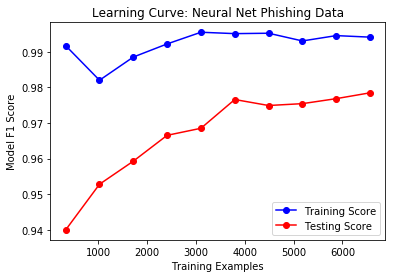

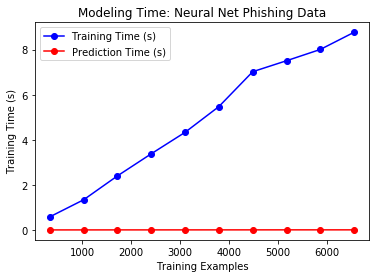

Evaluation Metrics Using Test Data
Training Time (s):   4.64230
Prediction Time (s): 0.01413

F1 Score:  0.97
Accuracy:  0.96
AUC:  0.96
Precision: 0.96
Recall:  0.97


<Figure size 432x288 with 0 Axes>

In [20]:
estimator_phish = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', learning_rate_init=learn_rate, random_state=100)

train_samp_phish, NN_train_score_phish, NN_fit_time_phish, NN_pred_time_phish = plot_learning_curve(estimator_phish, X_train, y_train,title="Neural Net Phishing Data")

final_classifier_evaluation(estimator_phish, X_train, X_test, y_train, y_test)


#  SVM

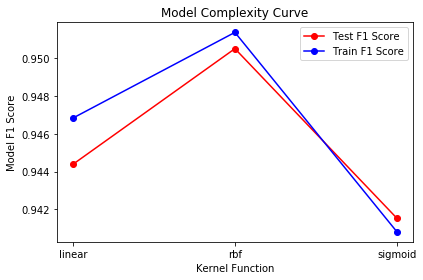

In [36]:
from sklearn.svm import SVC

title="Model Complexity Curve"
f1_test = []
f1_train = []
kernel_func = ['linear','rbf','sigmoid']
for i in kernel_func:
    clf = SVC(kernel=i, random_state=100)
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    f1_test.append(f1_score(y_test, y_pred_test))
    f1_train.append(f1_score(y_train, y_pred_train))


    
xvals = ['linear','rbf','sigmoid']
plt.plot(xvals, f1_test, 'o-', color='r', label='Test F1 Score')
plt.plot(xvals, f1_train, 'o-', color = 'b', label='Train F1 Score')
plt.ylabel('Model F1 Score')
plt.xlabel('Kernel Function')
    
plt.title(title)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [22]:
Cs = [1e-3, 1e-2, 1e-1, 1, 3]
gammas = [0.1, 0.5, 1, 10, 50]
param_grid = {'C': Cs, 'gamma': gammas}

clf = GridSearchCV(estimator = SVC(kernel='rbf',random_state=100), param_grid=param_grid, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print("Per Hyperparameter tuning, best parameters are:")
print(clf.best_params_)
C_val = clf.best_params_['C']
gamma_val = clf.best_params_['gamma']


Per Hyperparameter tuning, best parameters are:
{'C': 3, 'gamma': 0.5}


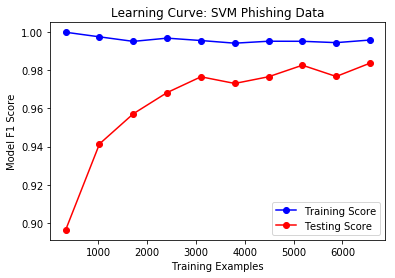

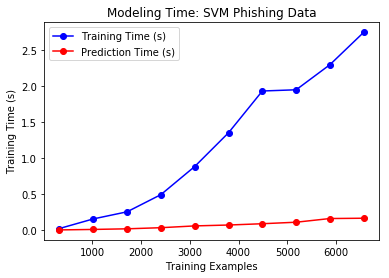

Evaluation Metrics Using Test Data
Training Time (s):   1.65421
Prediction Time (s): 0.70327

F1 Score:  0.97
Accuracy:  0.97
AUC:  0.97
Precision: 0.97
Recall:  0.97


<Figure size 432x288 with 0 Axes>

In [23]:

estimator_phish = SVC(C=C_val, gamma=gamma_val, kernel='rbf', random_state=100)
train_samp_phish, SVM_train_score_phish, SVM_fit_time_phish, SVM_pred_time_phish = plot_learning_curve(estimator_phish, X_train, y_train,title="SVM Phishing Data")
final_classifier_evaluation(estimator_phish, X_train, X_test, y_train, y_test)


# KNN

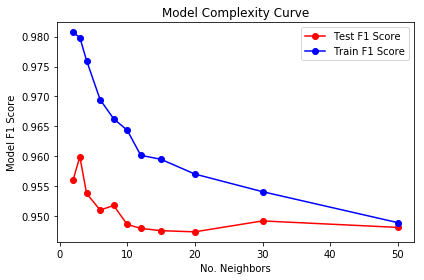

best number of k =  3


In [24]:
from sklearn.neighbors import KNeighborsClassifier as kNN
f1_test = []
f1_train = []
klist = [2,3,4,6,8,10,12,15,20,30,50]
bestk=1
besttest=0
for i in klist:
    clf = kNN(n_neighbors=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    f1_test.append(f1_score(y_test, y_pred_test))
    f1_train.append(f1_score(y_train, y_pred_train))
    if f1_score(y_test, y_pred_test) > besttest:
        besttest=f1_score(y_test, y_pred_test)
        bestk=i
        
plt.plot(klist, f1_test, 'o-', color='r', label='Test F1 Score')
plt.plot(klist, f1_train, 'o-', color = 'b', label='Train F1 Score')
plt.ylabel('Model F1 Score')
plt.xlabel('No. Neighbors')
    
plt.title(title)
plt.legend(loc='best')
plt.tight_layout()
plt.show()
print ('best number of k = ',bestk)

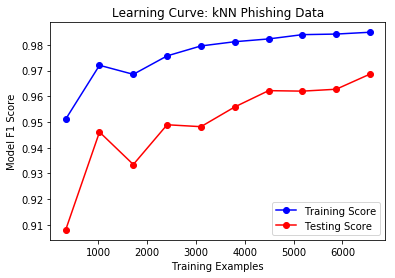

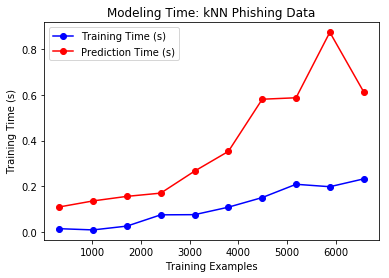

Evaluation Metrics Using Test Data
Training Time (s):   0.04458
Prediction Time (s): 0.64979

F1 Score:  0.96
Accuracy:  0.96
AUC:  0.95
Precision: 0.96
Recall:  0.96


<Figure size 432x288 with 0 Axes>

In [25]:
estimator_phish = kNN(n_neighbors=bestk, n_jobs=-1)
train_samp_phish, kNN_train_score_phish, kNN_fit_time_phish, kNN_pred_time_phish = plot_learning_curve(estimator_phish, X_train, y_train,title="kNN Phishing Data")
final_classifier_evaluation(estimator_phish, X_train, X_test, y_train, y_test)


# compare 5 algorithms

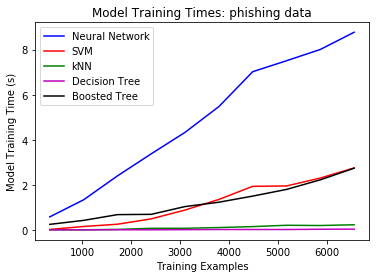

In [26]:
n, NNtime, SMVtime, kNNtime, DTtime, BTtime = train_samp_phish, NN_fit_time_phish, SVM_fit_time_phish, kNN_fit_time_phish,DT_fit_time_phish, BT_fit_time_phish  
datatitle='phishing data'
plt.figure()
plt.title("Model Training Times: " + datatitle)
plt.xlabel("Training Examples")
plt.ylabel("Model Training Time (s)")
plt.plot(n, NNtime, '-', color="b", label="Neural Network")
plt.plot(n, SMVtime, '-', color="r", label="SVM")
plt.plot(n, kNNtime, '-', color="g", label="kNN")
plt.plot(n, DTtime, '-', color="m", label="Decision Tree")
plt.plot(n, BTtime, '-', color="k", label="Boosted Tree")
plt.legend(loc="best")
plt.show()

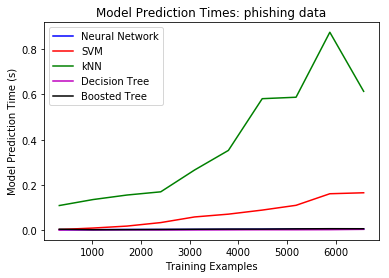

In [27]:
n,NNpred, SMVpred, kNNpred, DTpred, BTpred = train_samp_phish, NN_pred_time_phish, SVM_pred_time_phish, kNN_pred_time_phish, DT_pred_time_phish, BT_pred_time_phish   

plt.figure()
plt.title("Model Prediction Times: " + datatitle)
plt.xlabel("Training Examples")
plt.ylabel("Model Prediction Time (s)")
plt.plot(n, NNpred, '-', color="b", label="Neural Network")
plt.plot(n, SMVpred, '-', color="r", label="SVM")
plt.plot(n, kNNpred, '-', color="g", label="kNN")
plt.plot(n, DTpred, '-', color="m", label="Decision Tree")
plt.plot(n, BTpred, '-', color="k", label="Boosted Tree")
plt.legend(loc="best")
plt.show()

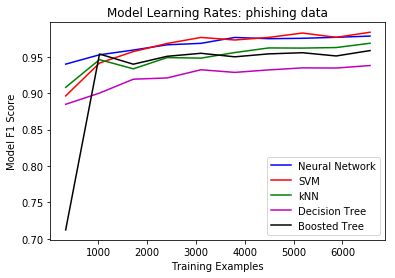

In [28]:
n,NNlearn, SMVlearn, kNNlearn, DTlearn, BTlearn = train_samp_phish, NN_train_score_phish, SVM_train_score_phish, kNN_train_score_phish, DT_train_score_phish, BT_train_score_phish  


plt.figure()
plt.title("Model Learning Rates: " + datatitle)
plt.xlabel("Training Examples")
plt.ylabel("Model F1 Score")
plt.plot(n, NNlearn, '-', color="b", label="Neural Network")
plt.plot(n, SMVlearn, '-', color="r", label="SVM")
plt.plot(n, kNNlearn, '-', color="g", label="kNN")
plt.plot(n, DTlearn, '-', color="m", label="Decision Tree")
plt.plot(n, BTlearn, '-', color="k", label="Boosted Tree")
plt.legend(loc="best")
plt.show() 